In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn import metrics,model_selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import glob
from scipy import stats
import datetime as dt
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dropout,Flatten,Dense

In [51]:
ACC = pd.read_csv("acceleration.txt", sep = ' ',names=['timedelta', 'accX', 'accY', 'accZ'])
HeartR = pd.read_csv("heartrate.txt", sep = ',',names=['timedelta', 'heartrate'])
SleepL = pd.read_csv("labeled_sleep.txt", sep = ' ',names=['timedelta', 'sleep'])

In [94]:
ACC

,timedelta,accX,accY,accZ
0,-124489.161050,0.017487,-0.586700,-0.805771
1,-124489.116395,0.018982,-0.589676,-0.809158
2,-124489.115548,0.020966,-0.580887,-0.815048
3,-124489.114691,0.019485,-0.580872,-0.813583
4,-124489.097700,0.016998,-0.587204,-0.806259
...,...,...,...,...
981995,17642.967007,0.505249,0.425720,-0.748764
981996,17642.987576,0.508194,0.429138,-0.750717
981997,17643.006946,0.508179,0.427200,-0.747284
981998,17643.026865,0.505737,0.427673,-0.749741


In [95]:
HeartR

,timedelta,heartrate
0,-556410.36066,57
1,-556408.36062,56
2,-556403.36062,56
3,-556399.36062,57
4,-556389.36062,59
...,...,...
4873,16959.47229,72
4874,16964.47229,74
4875,16970.47229,75
4876,16975.47229,76


In [96]:
SleepL

,timedelta,sleep
0,0,-1
1,30,-1
2,60,-1
3,90,-1
4,120,-1
...,...,...
562,16860,0
563,16890,0
564,16920,0
565,16950,0


In [52]:
# Check ‘timedelta’ max(), min() of ACC, HeartR, SleepL
ACC_max_date = ACC["timedelta"].max()
ACC_min_date = ACC["timedelta"].min()

In [99]:
print(ACC_max_date)
print(ACC_min_date)

17643.046417
-124489.16105


In [53]:
HR_max_date = HeartR["timedelta"].max()
HR_min_date = HeartR["timedelta"].min()

In [100]:
print(HR_max_date)
print(HR_min_date)

16980.47229
-556410.36066


In [54]:
Slp_max_date = SleepL["timedelta"].max()
Slp_min_date = SleepL["timedelta"].min()

In [102]:
print(Slp_max_date)
print(Slp_min_date)

16980
0


In [55]:
print("Acc Start : ",ACC_min_date," Acc End : ",ACC_max_date)

Acc Start :  -124489.16105  Acc End :  17643.046417


In [56]:
print("HeartR Start : ",HR_min_date," HeartR End : ",HR_max_date)

HeartR Start :  -556410.36066  HeartR End :  16980.47229


In [57]:
print("SleepL Start : ",Slp_min_date," SleepL End : ",Slp_max_date)

SleepL Start :  0  SleepL End :  16980


In [58]:
ACC_new = ACC[(ACC["timedelta"]> ACC_min_date) & (ACC["timedelta"] < ACC_max_date) & (ACC["timedelta"]> HR_min_date) & (ACC["timedelta"] < HR_max_date) &(ACC["timedelta"]> Slp_min_date) & (ACC["timedelta"] < Slp_max_date)]
HeartR_new = HeartR[(HeartR["timedelta"]> ACC_min_date) & (HeartR["timedelta"] < ACC_max_date) & (HeartR["timedelta"]> HR_min_date) & (HeartR["timedelta"] < HR_max_date) &(HeartR["timedelta"]> Slp_min_date) & (HeartR["timedelta"] < Slp_max_date)]
SleepL_new = SleepL[(SleepL["timedelta"]> ACC_min_date) & (SleepL["timedelta"] < ACC_max_date) & (SleepL["timedelta"]> HR_min_date) & (SleepL["timedelta"] < HR_max_date) &(SleepL["timedelta"]> Slp_min_date) & (SleepL["timedelta"] < Slp_max_date)]

In [59]:
ACC_new['timedelta'] = pd.DataFrame(pd.to_timedelta(ACC_new['timedelta'], 'seconds').round('1s'))

C:\Users\Burapa\AppData\Local\Temp\ipykernel_11308\2744463545.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ACC_new['timedelta'] = pd.DataFrame(pd.to_timedelta(ACC_new['timedelta'], 'seconds').round('1s'))


In [60]:
# Average rounding duplicated time
df_acc_X = ACC_new.groupby('timedelta')['accX'].mean()
df_acc_Y = ACC_new.groupby('timedelta')['accY'].mean()
df_acc_Z = ACC_new.groupby('timedelta')['accZ'].mean()


In [61]:
ACC_new2 = pd.concat([df_acc_X, df_acc_Y, df_acc_Z], axis=1)
ACC_new2 = ACC_new2.reset_index()

In [62]:
ACC_new2['timedelta'] = ACC_new2['timedelta'] - ACC_new2['timedelta'].min()
print(ACC_new2)

            timedelta      accX      accY      accZ
0     0 days 00:00:00 -0.243203  0.895372  0.367591
1     0 days 00:00:01 -0.240757  0.873826  0.415446
2     0 days 00:00:02 -0.244620  0.883943  0.387026
3     0 days 00:00:03 -0.248036  0.902427  0.347812
4     0 days 00:00:04 -0.241778  0.912946  0.321502
...               ...       ...       ...       ...
16976 0 days 04:42:56 -0.442763 -0.525892  0.722950
16977 0 days 04:42:57 -0.441990 -0.525476  0.723410
16978 0 days 04:42:58 -0.441581 -0.525116  0.724003
16979 0 days 04:42:59 -0.442283 -0.525849  0.723265
16980 0 days 04:43:00 -0.442674 -0.525962  0.722678

[16981 rows x 4 columns]


In [63]:
HeartR_new['timedelta'] = pd.DataFrame(pd.to_timedelta(HeartR_new['timedelta'],"seconds").round('1s'))

C:\Users\Burapa\AppData\Local\Temp\ipykernel_11308\1047144339.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HeartR_new['timedelta'] = pd.DataFrame(pd.to_timedelta(HeartR_new['timedelta'],"seconds").round('1s'))


In [64]:
# Resampling every 1s with median with ffill
resample_rule = '1s'
HeartR_new2 = HeartR_new.set_index('timedelta').resample(resample_rule,).median().ffill()
HeartR_new2 = HeartR_new2.reset_index()

In [65]:
HeartR_new2['timedelta'] = HeartR_new2['timedelta'] - HeartR_new2['timedelta'].min()
print(HeartR_new2)


            timedelta  heartrate
0     0 days 00:00:00       97.0
1     0 days 00:00:01       97.0
2     0 days 00:00:02       97.0
3     0 days 00:00:03       97.0
4     0 days 00:00:04       97.0
...               ...        ...
16963 0 days 04:42:43       75.0
16964 0 days 04:42:44       75.0
16965 0 days 04:42:45       75.0
16966 0 days 04:42:46       75.0
16967 0 days 04:42:47       76.0

[16968 rows x 2 columns]


In [66]:
# ------------ Rounding Sleep Label (Rounding to 1 sec) -------------------------------
SleepL_new['timedelta'] = pd.DataFrame(pd.to_timedelta(SleepL_new['timedelta'],"seconds").round('1s'))

C:\Users\Burapa\AppData\Local\Temp\ipykernel_11308\4139669861.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SleepL_new['timedelta'] = pd.DataFrame(pd.to_timedelta(SleepL_new['timedelta'],"seconds").round('1s'))


In [67]:
# Resampling every 1s with median with ffill
resample_rule = '1s'
SleepL_new2 = SleepL_new.set_index('timedelta').resample(resample_rule,).median().ffill()
SleepL_new2 = SleepL_new2.reset_index()

In [68]:
SleepL_new2['timedelta'] = SleepL_new2['timedelta'] - SleepL_new2['timedelta'].min()
print(SleepL_new2)

            timedelta  sleep
0     0 days 00:00:00   -1.0
1     0 days 00:00:01   -1.0
2     0 days 00:00:02   -1.0
3     0 days 00:00:03   -1.0
4     0 days 00:00:04   -1.0
...               ...    ...
16916 0 days 04:41:56    0.0
16917 0 days 04:41:57    0.0
16918 0 days 04:41:58    0.0
16919 0 days 04:41:59    0.0
16920 0 days 04:42:00    0.0

[16921 rows x 2 columns]


In [69]:
# ------------Merge All Data -------------------------------
HeartR_new2['heartrate'].fillna(HeartR_new2.median())
SleepL_new2.replace({-1:0},inplace=True)
SleepL_new2['sleep'].fillna(0)
df = []
df = pd.merge_asof(ACC_new2, HeartR_new2, on='timedelta')
df = pd.merge_asof(df, SleepL_new2, on = 'timedelta')
print(df)

            timedelta      accX      accY      accZ  heartrate  sleep
0     0 days 00:00:00 -0.243203  0.895372  0.367591       97.0    0.0
1     0 days 00:00:01 -0.240757  0.873826  0.415446       97.0    0.0
2     0 days 00:00:02 -0.244620  0.883943  0.387026       97.0    0.0
3     0 days 00:00:03 -0.248036  0.902427  0.347812       97.0    0.0
4     0 days 00:00:04 -0.241778  0.912946  0.321502       97.0    0.0
...               ...       ...       ...       ...        ...    ...
16976 0 days 04:42:56 -0.442763 -0.525892  0.722950       76.0    0.0
16977 0 days 04:42:57 -0.441990 -0.525476  0.723410       76.0    0.0
16978 0 days 04:42:58 -0.441581 -0.525116  0.724003       76.0    0.0
16979 0 days 04:42:59 -0.442283 -0.525849  0.723265       76.0    0.0
16980 0 days 04:43:00 -0.442674 -0.525962  0.722678       76.0    0.0

[16981 rows x 6 columns]


In [70]:
# Drop column
df.drop(columns = ['timedelta'],inplace = True)
print(df)

           accX      accY      accZ  heartrate  sleep
0     -0.243203  0.895372  0.367591       97.0    0.0
1     -0.240757  0.873826  0.415446       97.0    0.0
2     -0.244620  0.883943  0.387026       97.0    0.0
3     -0.248036  0.902427  0.347812       97.0    0.0
4     -0.241778  0.912946  0.321502       97.0    0.0
...         ...       ...       ...        ...    ...
16976 -0.442763 -0.525892  0.722950       76.0    0.0
16977 -0.441990 -0.525476  0.723410       76.0    0.0
16978 -0.441581 -0.525116  0.724003       76.0    0.0
16979 -0.442283 -0.525849  0.723265       76.0    0.0
16980 -0.442674 -0.525962  0.722678       76.0    0.0

[16981 rows x 5 columns]


In [71]:
# Standardized data
standard_scaler = StandardScaler()
feature_columns = ['accX', 'accY', 'accZ', 'heartrate']
label_columns = ['sleep']
df_feature = df[feature_columns] #standardized data of df_feature
df_feature = pd.DataFrame(standard_scaler.fit_transform(df_feature.values),index = df_feature.index,columns=df_feature.columns)
print(df_feature)
df_label = df[label_columns]
print(df_label)

           accX      accY      accZ  heartrate
0     -0.587547  3.058075  0.698728   2.078705
1     -0.581456  2.995094  0.757746   2.078705
2     -0.591075  3.024668  0.722696   2.078705
3     -0.599581  3.078699  0.674335   2.078705
4     -0.583998  3.109450  0.641889   2.078705
...         ...       ...       ...        ...
16976 -1.084456 -1.096565  1.136974  -0.630035
16977 -1.082531 -1.095348  1.137542  -0.630035
16978 -1.081511 -1.094296  1.138273  -0.630035
16979 -1.083260 -1.096440  1.137363  -0.630035
16980 -1.084234 -1.096769  1.136639  -0.630035

[16981 rows x 4 columns]
       sleep
0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
...      ...
16976    0.0
16977    0.0
16978    0.0
16979    0.0
16980    0.0

[16981 rows x 1 columns]


In [72]:
# ------------ 1D to 3D feature-------------------------------
# set sliding window parameter
slidingW = 100
Stride_step = 5
n_features = 4 #number of colums form df_feature
df_feature3D = np.array([],ndmin=2)
df_label_new = np.array([])

In [73]:
for t in range(0 , len(df_feature), Stride_step ):
    F3d = np.array(df_feature[t:t+slidingW],ndmin=2)
    # print(F3d[0])
    if len(F3d) <slidingW:
        break
    F3d.reshape(slidingW, n_features,1)
    # print(df_feature3D.shape)
    # print(F3d.shape)
    if df_feature3D.size == 0 :
        df_feature3D = F3d
    else:
        df_feature3D = np.dstack((df_feature3D,F3d))
    Labels = stats.mode(df_label[t : t+slidingW])
    # print(Labels)
    df_label_new = np.append(df_label_new,Labels[0])
df_feature3D = np.swapaxes(df_feature3D,0,2)
df_feature3D = np.swapaxes(df_feature3D,1,2)
df_feature3D = df_feature3D[..., np.newaxis]

C:\Users\Burapa\AppData\Local\Temp\ipykernel_11308\844412072.py:13: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  Labels = stats.mode(df_label[t : t+slidingW])


In [74]:
print(df_feature3D.shape)

(3377, 100, 4, 1)


In [75]:
print(df_label_new.shape)

(3377,)


In [76]:
rseed=42
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(df_feature, df_label, test_size=0.3, random_state=rseed)


In [77]:
# ------------ Train-Test-Split 3D features -------------------------------
x3D_train, x3D_test, y3D_train, y3D_test = model_selection.train_test_split(df_feature3D, df_label_new, test_size=0.3, random_state=rseed)


In [78]:
# ------------ NN Architecture parameter -------------------------------
Hidden_Layer_param = (30, 30, 30)
mlp = MLPClassifier(hidden_layer_sizes = Hidden_Layer_param)
# View NN model parameters

In [79]:
    # ------------ Training NN using 1D features -------------------------------
mlp.fit(X_train,Y_train)
mlp_pred = mlp.predict(X_test)
print(confusion_matrix(Y_test,mlp_pred))

c:\Users\Burapa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[ 702   13  105   28    8]
 [  39  121   75    2    8]
 [  17   25 1351   35   94]
 [   5    0  115 1339    0]
 [   0    2    2    0 1009]]


In [80]:
print(classification_report(Y_test,mlp_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.82      0.87       856
         1.0       0.75      0.49      0.60       245
         2.0       0.82      0.89      0.85      1522
         3.0       0.95      0.92      0.94      1459
         5.0       0.90      1.00      0.95      1013

    accuracy                           0.89      5095
   macro avg       0.87      0.82      0.84      5095
weighted avg       0.89      0.89      0.89      5095



In [81]:
# ------------ CNN Architecture parameter -------------------------------
# Nlayer (CNN, dense), Nnode, Activation
CNN_L1 = 16
CNN_L2 = 64
CNN_L3 = 128
D_L1 = 512
D_out = 6
Activation = "relu"
Ker_size = (3,3)
Pooling_size = (2,1)
Input_shape = (slidingW, n_features, 1)

In [82]:
# ------------ Create CNN Model -------------------------------
model = models.Sequential()
model.add(Conv2D(CNN_L1, kernel_size=Ker_size, activation=Activation,input_shape=Input_shape,padding='same'))
model.add(MaxPooling2D(pool_size=Pooling_size))
model.add(Dropout(0.4))
model.add(Conv2D(CNN_L2, kernel_size=Ker_size, activation= Activation, padding='same'))
model.add(MaxPooling2D(pool_size= Pooling_size))
model.add(Dropout(0.4))
model.add(Conv2D(CNN_L3, kernel_size=Ker_size, activation= Activation,padding='same'))
model.add(MaxPooling2D(pool_size= Pooling_size))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(D_L1 , activation= Activation ))
model.add(Dense(D_out, activation='sigmoid'))
model.compile(optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 100, 4, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 50, 4, 16)        0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 50, 4, 16)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 50, 4, 64)         9280      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 25, 4, 64)        0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 25, 4, 64)        

In [83]:
# ------------ Create Optimizer -------------------------------
model.compile(optimizer='adam',loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=["acc"])


In [85]:
# ------ Train CNN using 3D feature--------------------------------------------
history = model.fit(x3D_train, y3D_train, epochs=50, batch_size=64,validation_data=(x3D_test, y3D_test))

Epoch 1/50


c:\Users\Burapa\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


37/37 [==============================] - 8s 164ms/step - loss: 1.0981 - acc: 0.5612 - val_loss: 0.7468 - val_acc: 0.6805
Epoch 2/50
37/37 [==============================] - 5s 140ms/step - loss: 0.5877 - acc: 0.7647 - val_loss: 0.6150 - val_acc: 0.7456
Epoch 3/50
37/37 [==============================] - 5s 138ms/step - loss: 0.4993 - acc: 0.8041 - val_loss: 0.5174 - val_acc: 0.8047
Epoch 4/50
37/37 [==============================] - 5s 127ms/step - loss: 0.4726 - acc: 0.8100 - val_loss: 0.5070 - val_acc: 0.7919
Epoch 5/50
37/37 [==============================] - 5s 127ms/step - loss: 0.4122 - acc: 0.8320 - val_loss: 0.3953 - val_acc: 0.8481
Epoch 6/50
37/37 [==============================] - 5s 123ms/step - loss: 0.3743 - acc: 0.8481 - val_loss: 0.3622 - val_acc: 0.8649
Epoch 7/50
37/37 [==============================] - 5s 122ms/step - loss: 0.3307 - acc: 0.8658 - val_loss: 0.3470 - val_acc: 0.8669
Epoch 8/50
37/37 [==============================] - 5s 122ms/step - loss: 0.3349 - acc:

In [86]:
# ------- Test CNN -------------------------------
# CNN_pred = model.predict(x3D_test)
CNN_pred = np.argmax(model.predict(x3D_test),axis=1)
print(CNN_pred)

32/32 [==============================] - 1s 21ms/step
[0 0 5 ... 5 2 5]


In [87]:
print(y3D_test)

[0. 0. 2. ... 5. 3. 5.]


In [88]:
# ------------ View Confusion Matrix, Classification Report -------------------------------
print(confusion_matrix(y3D_test,CNN_pred))

[[159   4  23   0   0]
 [  0  36  12   0   1]
 [  3   3 284   7  14]
 [  0   0   3 274   0]
 [  0   1   0   0 190]]


In [89]:
print(classification_report(y3D_test,CNN_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.85      0.91       186
         1.0       0.82      0.73      0.77        49
         2.0       0.88      0.91      0.90       311
         3.0       0.98      0.99      0.98       277
         5.0       0.93      0.99      0.96       191

    accuracy                           0.93      1014
   macro avg       0.92      0.90      0.91      1014
weighted avg       0.93      0.93      0.93      1014



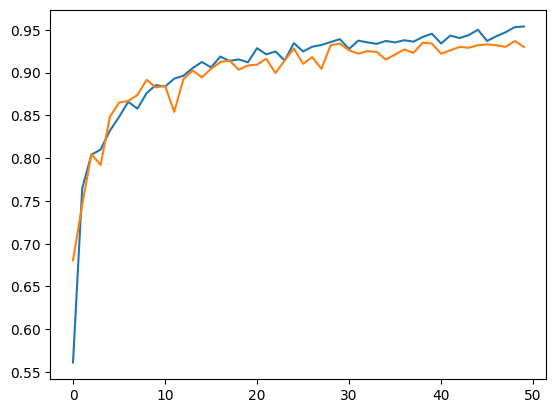

In [92]:
# ------ View History Graph -------------------------------------------
# View Accuracy Graph
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

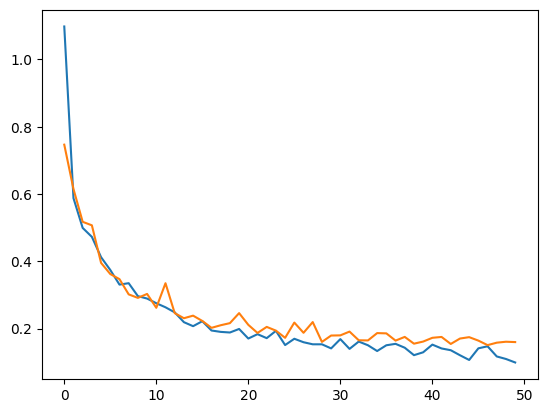

In [91]:
# View Loss Graph
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [ ]:
# View Loss Graph
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()